https://watermark.silverchair.com/tacl_a_00008.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqkwggKlBgkqhkiG9w0BBwagggKWMIICkgIBADCCAosGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMdPHYXwG3pcrWAWblAgEQgIICXLAPHfS6DARCCcJOQgNOoHW0d6UCjs3oxS-PWDFPOk7X9faJxJOnQ5Uw6pVYoyKusEjj9WPNYLS9lXu3It3oT9_evEDplawruHZ6wGGCRQaE2lL6UnFonGuX2VA_B78COLDzUNsLq7H8HJxYcnM69qXSXtecSG0BgIxzl5GDuJjEnmw7s0l-fCwtKeu31OCom2mdkQZVvow05n1a1POX4yb_IHr0BfUu2_jpJJdhXp7CT8PuH0NFUwgf9R6nEnQxV0iMnb-31-MrLir4VL1KpJGYvTWhGRYGWgW76E5iSGpIShl47bzyPQcmzwrtv1H5JtOCQ38Xom6pQLb8gX5xlPTnEHxykR2yV_eDu9WlUkty_AHo-CIipkLzW18YDmVAopNNJtBDM6PwA0AzEdhzTk3hM2L2rsevblwlZMyGvpuvxnentatFdU5P8NI7beqdveY8ff0TID8C1lB5u3ZmeYPmcAytAdVt9yyD3iMCRO8CUntiIxJaX6QO0QzI9KPlW3-3RM4WqRq-ZCA3sb9jsLuaftRhEebIGEh_O5zH_H4r6K--NZWNXsEtrbTKWhgTuTTCaUfRIab88OV0MvyBj6S59SwcjSfJnJjOLVXG0d8LqRNuld2eDe-mBUm1PoeLEFrrCfNArKe-GyXejS68fN4bxzKF3vcJWnG054eJG95zvDY0xQeyvPGp0EVqh26f7sQ3O21AHBnqKTL9IvIhHZk3Ytvl9R_-_q26JdmVX-Qve7vU1T5XEHofsvq48CUgG4kNo8CX4cuuM64tEGOCtB6p41tvLhT_TQdFKso

In [1]:
!pwd

/Users/furiosa/Documents/repos/paper_greekparliament/twec/twec


### Train 

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime
import re
import os
tqdm.pandas()
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
from tabulate import tabulate
import itertools


/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]

(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [3]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [11]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

10576             κυριοι συναδελφοι αρχιζει @sw συνεδριαση
10577    κυριοι συναδελφοι @sw προχωρησουμε @sw ορκωμοσ...
10578                                          αξιος αξιος
10579                                          αξιος αξιος
Name: speech, dtype: object

In [5]:
#New column year
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove dates after 2019 to catch the three last decades
df = df[df.decade != 2000]# remove dates after 2019 to catch the three last decades

print(set(df.decade.to_list()))

{2010, 1990}


In [57]:
# df.speech = df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
# print('Group by decades...')
# print(datetime.datetime.now())
# PERdecade_df = df.groupby(df.decade)['speech'].progress_apply(sum).reset_index()
# print(datetime.datetime.now())

print(datetime.datetime.now())

print('Group by decades...')
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply('. '.join).reset_index() # add missing dot from end of sentence
print('Tokenize...')
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [token for token in x if token!='' and token!=' '])

print(datetime.datetime.now())

  0%|          | 0/2 [00:00<?, ?it/s]

2021-04-16 02:12:27.329115
Group by decades...


  0%|          | 0/2 [00:00<?, ?it/s]

Tokenize...


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

2021-04-16 02:21:51.961425


In [58]:
# PERdecade_df.speech[0] = PERdecade_df.speech[0][:10000]
# PERdecade_df.speech[1] = PERdecade_df.speech[1][:10000]
# print(len(PERdecade_df.speech.iloc[0]))
# print(len(PERdecade_df.speech.iloc[1]))

/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


10000
10000


/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
models_dir =  '../out_files/wordmodels/goldberg_decade_2/'

https://stackoverflow.com/questions/34831551/ensure-the-gensim-generate-the-same-word2vec-model-for-different-runs-on-the-sam
https://stackoverflow.com/questions/54865930/how-to-set-pythonhashseed-for-jupyter-notebook

In [60]:
import random

def train_word2vec(PERdecade_df, iteration, my_seed):
    
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    print('Start training')
    print(datetime.datetime.now())

    for decade, texts in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
        model = Word2Vec(sentences=texts, size=300, window=4, min_count=20, workers=1, seed=my_seed)
        model.save(models_dir+str(decade) + '_' + str(iteration) + ".mdl")

    print(datetime.datetime.now()) 

    
for i in range(2): 
    
    if i==0:
        print('Training first model')
        %env PYTHONHASHSEED=999
        np.random.seed(999)
        random.seed(999)
        train_word2vec(PERdecade_df, i, 999)  
    else:
        print('Training second model')
        %env PYTHONHASHSEED=3
        np.random.seed(3)
        random.seed(3)
        train_word2vec(PERdecade_df, i, 3)    


0it [00:00, ?it/s]

Training first model
env: PYTHONHASHSEED=13
Start training
2021-04-16 02:22:42.780321


2it [00:03,  1.88s/it]
0it [00:00, ?it/s]

2021-04-16 02:22:46.553416
Training second model
env: PYTHONHASHSEED=64
Start training
2021-04-16 02:22:46.555487


2it [00:04,  2.43s/it]

2021-04-16 02:22:51.429133


### Collect words for semantic shift analysis that fulfill the thresholds

Count frequency of words for each decade

In [61]:
df_freq_1990 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade1990.csv')
df_freq_2010 = pd.read_csv('../out_files/freqs_for_semantic_shift_cleaned_data_decade2010.csv')

In [62]:
# most frequent words at the top
df_freq_1990 = df_freq_1990.sort_values('frequency', ascending=False)
df_freq_2010 = df_freq_2010.sort_values('frequency', ascending=False)

# collect 200 most frequent words
most_freq_1990 = df_freq_1990.word.head(200).to_list()
most_freq_2010 = df_freq_2010.word.head(200).to_list()

# collect words with less than 200 frequency
least_frequent_1990 = df_freq_1990.loc[df_freq_1990.frequency<200].word.to_list()
least_frequent_2010 = df_freq_2010.loc[df_freq_2010.frequency<200].word.to_list()

In [63]:
# Collect the intersection of the vocabularies that fulfill the frequency thresholds

def collect_words(iteration, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010):

    m1_vocab = [key for key, value in m1.wv.vocab.items() if key!=' ']
    m2_vocab = [key for key, value in m2.wv.vocab.items() if key!=' ']

#     print('1')
    # remove stopwords
    m1_vocab.remove('@sw')                   
    m2_vocab.remove('@sw')
#     print('2')

    # Clean words to search for usage change
    m1_vocab_final = [w for w in m1_vocab if w not in most_freq_1990 and w not in least_frequent_1990]
    m2_vocab_final = [w for w in m2_vocab if w not in most_freq_2010 and w not in least_frequent_2010]
#     print('3')

    final_list = set(m1_vocab_final).intersection(set(m2_vocab_final))
    print(len(final_list))
    
    return m1_vocab, m2_vocab, final_list


### Collect eligible neighbors that fulfill the thresholds

In [64]:
# Define the plausible neighbors to keep as neighbors to final_list words
# They must be in both vocabs and appear more than 100 times in each corpus

over100_1990_list = df_freq_1990.loc[(df_freq_1990.frequency>100), 'word'].to_list()
# print(len(over100_1990_list))
over100_2010_list = df_freq_2010.loc[(df_freq_2010.frequency>100), 'word'].to_list()
over100_intersection = set(over100_1990_list).intersection(set(over100_2010_list))

def collect_neighbors(m1_vocab, m2_vocab):
    intersection_vocabs = list(set(m1_vocab).intersection(set(m2_vocab)))
    intersection_vocabs.remove('')
    print("Vocabulary intersection: ", len(intersection_vocabs))

    plausible_neighbors = [w for w in intersection_vocabs if w in over100_intersection]
    return plausible_neighbors
    


### Compute semantic shift 

In [65]:
import time 

shifts_PERdecade_list=[]
error_list = []

print(datetime.datetime.now())

topn_neighbors = 1000

for i in range(2):
    print('Iteration ', str(i))
    
    m1 = Word2Vec.load(models_dir+'1990_'+str(i)+'.mdl')
    m2 = Word2Vec.load(models_dir+'2010_'+str(i)+'.mdl')
    
    m1_vocab, m2_vocab, final_list = collect_words(i, m1, m2, most_freq_1990, least_frequent_1990, most_freq_2010, least_frequent_2010)
    plausible_neighbors = collect_neighbors(m1_vocab, m2_vocab)
    

    for word in tqdm(final_list):
    #     print(word)

        #union of neighbors in two points in time
        neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[word], topn=5000) if w in plausible_neighbors]
    #     print(len(neighbors_t1))
        neighbors_t1 = neighbors_t1[:topn_neighbors]
        neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[word], topn=5000) if w in plausible_neighbors]
    #     print(len(neighbors_t2))
        neighbors_t2 = neighbors_t2[:topn_neighbors]

        if len(neighbors_t1)<topn_neighbors or len(neighbors_t2)<topn_neighbors:
            error_list.append([word, len(neighbors_t1), len(neighbors_t2)])

        score = -len(set(neighbors_t1).intersection(set(neighbors_t2)))
    #     print(score)
        shifts_PERdecade_list.append([word, i, '1990-2010', score, neighbors_t1, neighbors_t2])
    #     break

print(datetime.datetime.now())


2021-04-16 02:22:54.173793
Iteration  0


  1%|          | 4/322 [00:00<00:10, 30.31it/s]

322
Vocabulary intersection:  544


100%|██████████| 322/322 [00:17<00:00, 18.24it/s]


Iteration  1


  1%|          | 4/322 [00:00<00:08, 36.63it/s]

322
Vocabulary intersection:  544


100%|██████████| 322/322 [00:18<00:00, 17.83it/s]

2021-04-16 02:24:21.408921


In [66]:
shifts_PERdecade_df = pd.DataFrame(shifts_PERdecade_list, columns = ['word', 'iteration', 'decade',
                                                                 'score', 'neighbors_t1',
                                                                    'neighbors_t2'])
print(shifts_PERdecade_df.head())

          word  iteration     decade  score  \
0                       0  1990-2010    -60   
1         πανε          0  1990-2010    -27   
2     εισφορες          0  1990-2010    -27   
3         μηνα          0  1990-2010    -31   
4  τροποποιηση          0  1990-2010    -38   

                                        neighbors_t1  \
0  [παρακαλω, λογο, οριστε, προεδρε, παπακωνσταντ...   
1  [τριτον, ταμειο, συμβαση, συμβασεις, αδεια, αν...   
2  [δαπανων, διαστημα, δαπανες, αδυναμια, ανεργια...   
3  [παραγωγη, δισεκατομμυρια, αποτελεσματα, πεντε...   
4  [πεντε, επιτροπης, μηνα, παραγωγη, δισεκατομμυ...   

                                        neighbors_t2  
0  [ευχαριστω, προεδρε, συναδελφε, παρακαλω, κυρι...  
1  [διαστημα, εργαζομενοι, εργαζομενων, προστασια...  
2  [κατασκευη, παραδειγμα, εργαζομενοι, στοιχεια,...  
3  [νομοσχεδιου, εφοσον, συμβαση, ισχυει, ποσοστο...  
4  [τριων, εργων, αναφερεται, ψηφιση, τριτον, ασφ...  


In [67]:
print(len(error_list))

0


In [73]:
set(shifts_PERdecade_df.iteration.to_list())
jjj = shifts_PERdecade_df.word[1]
print(jjj)
print(shifts_PERdecade_df.loc[(shifts_PERdecade_df.word==jjj)])

πανε
     word  iteration     decade  score  \
323  πανε          1  1990-2010    -28   
1    πανε          0  1990-2010    -27   

                                          neighbors_t1  \
323  [προυποθεσεις, παραδειγμα, ασφαλιστικα, υποθεσ...   
1    [τριτον, ταμειο, συμβαση, συμβασεις, αδεια, αν...   

                                          neighbors_t2  
323  [ταμειο, πρωτον, πληρωνει, δαπανες, προστασια,...  
1    [διαστημα, εργαζομενοι, εργαζομενων, προστασια...  


In [ ]:
print(shifts_PERdecade_df.describe())

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('score')

print('Words with the lowest score/ lowest change')
print(shifts_PERdecade_df.head(20))

print('Words with the highest score / highest change')
print(shifts_PERdecade_df.tail(20))

shifts_PERdecade_df.to_csv('../out_files/stability_goldberg_2_iterations_dif_seeds_1_worker_2.csv', index=False)

In [51]:
# for iteration in range(3):
#     subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#     print(iteration)
#     print(subdf.head(10))
#     print(subdf.describe())
#     print('------------------------------------')

In [52]:
# decade_pairs = list(set(shifts_PERdecade_df.decade_pair.to_list()))
# for pair in sorted(decade_pairs):
#     print(pair)
#     decade_df = shifts_PERdecade_df.loc[(shifts_PERdecade_df.decade_pair==pair)].sort_values(by='semantic_similarity').reset_index(drop=True)
#     print(decade_df.describe())
#     print(decade_df.head(20))
# #     decade_df.head(20).to_csv('../../out_files/'+pair+'.csv')

In [53]:
# freq_df = pd.read_csv('../../out_files/freqs_for_semantic_shift_cleaned_data.csv')
# freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)

# print(freq_df.shape)
# # print(freq_df.frequency.to_list())

# pd.set_option('float_format', '{:f}'.format)

# freq_df.describe(percentiles = [0.2, 0.4, 0.6, 0.8])

# freq_subdf = freq_df.loc[(freq_df.frequency>200)] # at least 200 times
# print(freq_subdf.shape)
# freq_subdf = freq_subdf[200:]
# print(print(freq_subdf.shape))

# print(freq_subdf.shape)
# freq_subdf = freq_subdf.reset_index(drop=True)
# print(freq_subdf.tail(2))

In [54]:
# shifts_frequent_words = shifts_PERdecade_df.loc[(shifts_PERdecade_df.word.isin(freq_subdf.word.to_list()))].reset_index(drop=True)

# # add columns frequency and percentage in shifts_frequent_words based on the value of column word
# shifts_frequent_words = pd.merge(shifts_frequent_words, freq_subdf, on=['word'], how='left')   

# print(shifts_frequent_words.head(10))

# print(shifts_frequent_words.tail(2))

# shifts_frequent_words.describe()


[10, 20, 50, 100, 200, 500, 1000] [0.6, 0.85, 0.66, 0.62, 0.75, 0.644, 0.322]


Text(0.5, 1.0, 'Stability for Compass')

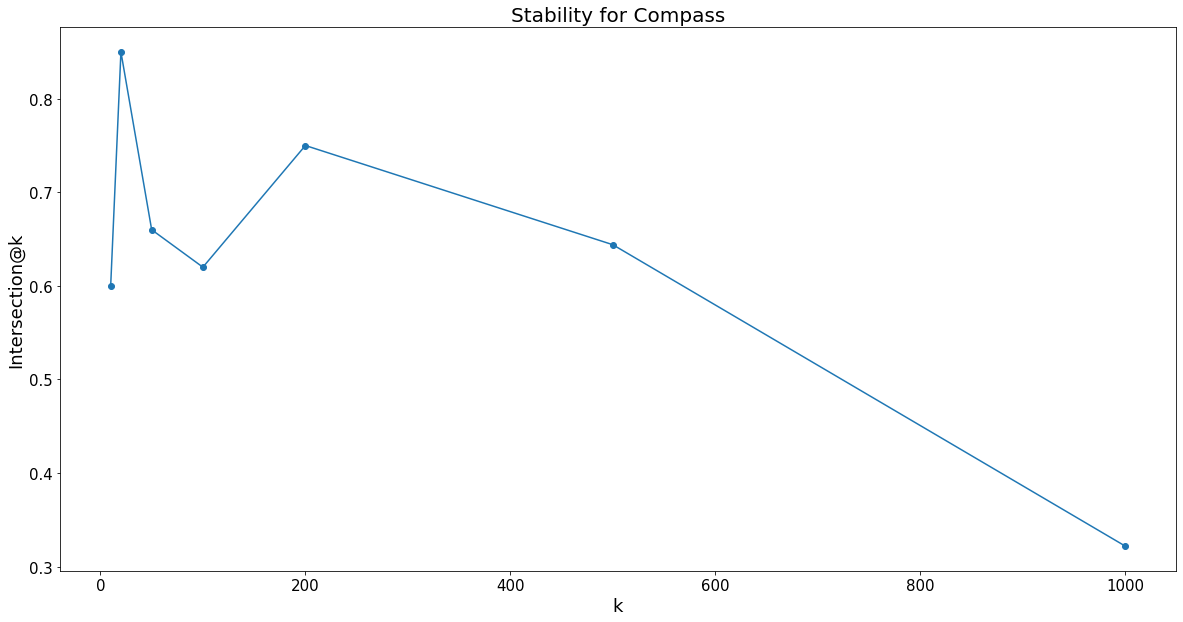

In [69]:
import matplotlib.pyplot as plt

topn_dict = {}
X = []
Y = []

k=[10,20,50,100,200,500,1000]

for n in k:
    
    for iteration in range(2):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#         print(subdf.shape)
    #     print(subdf.columns)
        subdf.sort_values('score', ascending=False).reset_index(drop=True)
    #     print(subdf.head(2))
        topn_dict[iteration] = subdf.head(n).word.to_list()

    intersection = len(set(topn_dict[0]).intersection(set(topn_dict[1])))
    
    Y.append(intersection/n)
    X.append(n)
    
print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)

plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Goldberg', fontsize=20)

plt.savefig('../out_files/stability_goldberg_2.png', dpi=200,  bbox_inches='tight')
